# Update 3

## Reading & Preparing Data

In [ ]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import statsmodels.api as sm
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
warnings.filterwarnings("ignore", message=".*frozen modules.*")
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet
import lightgbm as lgb

Mounted at /content/drive


In [ ]:
dir_data= "/content/drive/MyDrive/mini4/BizValue/Update1/data"

In [ ]:
### Data Ingestion
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped.

    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"

    all_files = os.listdir(directory)
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:

        if i.find('.csv')<0:
            continue

        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)


    return output

# Ingest the set of files we downloaded
files_data = ingest_files(dir_data)

data_now = pd.concat(files_data.values()).reset_index(drop = True)

# Identify the columns we'll be keeping from the dataset
cols_to_pick = [ #preselecetd
                'id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec',
                 'revol_bal','revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries',
                 #new selected
                 'acc_now_delinq', 'addr_state', 'bc_util','mort_acc',
                 'num_bc_sats', 'num_bc_tl', 'pct_tl_nvr_dlq',
                  'pub_rec_bankruptcies', 'tax_liens',
                 'total_acc', 'delinq_amnt', 'sub_grade']



# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq', 'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'total_acc', 'delinq_amnt']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose', 'addr_state', 'sub_grade']
perc_cols = ['int_rate', 'revol_util' ]
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

final_data = data_now[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

####Data Cleaning
for i in float_cols:
    final_data[i] = final_data[i].astype(float)

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )

for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

#Removing the id columns - since the id column is null
final_data.drop('id', axis=1, inplace=True)

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

final_data['credit_line_loan_gap'] = (final_data.issue_d - final_data.earliest_cr_line)/np.timedelta64(365, 'D')

float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq',
                                'collections_12_mths_ex_med', 'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'credit_line_loan_gap']

final_data = final_data.drop(columns = 'earliest_cr_line')

final_data['issue_d_temp'] = pd.to_datetime(final_data['issue_d'])

# extract full month name
final_data['issue_month'] = final_data['issue_d_temp'].dt.month_name()
final_data = final_data.drop(columns=['issue_d_temp'])
final_data.head().T

Directory /content/drive/MyDrive/mini4/BizValue/Update1/data/ has 3 files:
    Reading file 2014.csv
    Reading file 2015.csv
Starting with 656728 rows
Removed 7267 rows


,0,1,2,3,4
loan_amnt,15000.0,10400.0,7650.0,12800.0,21425.0
funded_amnt,15000.0,10400.0,7650.0,12800.0,21425.0
term,60 months,36 months,36 months,60 months,60 months
int_rate,12.39,6.99,13.66,17.14,15.59
installment,336.64,321.08,260.2,319.08,516.36
grade,C,A,C,D,D
emp_length,10+ years,8 years,< 1 year,10+ years,6 years
home_ownership,RENT,MORTGAGE,RENT,MORTGAGE,RENT
annual_inc,78000.0,58000.0,50000.0,125000.0,63800.0
verification_status,Source Verified,Not Verified,Source Verified,Verified,Source Verified


In [ ]:
# Create a binary target variable 'default'
# A loan is considered defaulted if its loan_status is "Charged Off"
final_data['default'] = final_data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off', 'Charged-Off'] else 0)

# Adding Return

# Addition of return
### Define the names of the four returns we'll be calculating

ret_cols = [ "ret_INTd"]

## Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) * 12 / np.timedelta64(365, 'D')

n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")


def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTd'] = ret_method_3(5*12, 0.00864)  #assumed given median annual interest rate is 10.99% which is the 25th percentile of inetrest rate distribution
final_data['return_pct'] = final_data['ret_INTd']
final_data['recovery_pct'] = final_data['recoveries'] / final_data['loan_amnt']

#Dropping all reduendant columns and unwanted columns
final_data.drop(columns=['ret_INTd','loan_length','loan_status','total_pymnt','last_pymnt_d','recoveries'], inplace=True)

Removed 1112 rows


In [ ]:
final_data.head().T

,0,1,2,3,4
loan_amnt,15000.0,10400.0,7650.0,12800.0,21425.0
funded_amnt,15000.0,10400.0,7650.0,12800.0,21425.0
term,60 months,36 months,36 months,60 months,60 months
int_rate,12.39,6.99,13.66,17.14,15.59
installment,336.64,321.08,260.2,319.08,516.36
grade,C,A,C,D,D
emp_length,10+ years,8 years,< 1 year,10+ years,6 years
home_ownership,RENT,MORTGAGE,RENT,MORTGAGE,RENT
annual_inc,78000.0,58000.0,50000.0,125000.0,63800.0
verification_status,Source Verified,Not Verified,Source Verified,Verified,Source Verified


### Shortlisting and encoding columns

In [ ]:
cols = ['loan_amnt','term','int_rate','installment',   #loan params
        'issue_d', #verification_status
        'verification_status','purpose','grade','issue_month',  #categorical loan params
        'credit_line_loan_gap','revol_util','bc_util','dti','emp_length','home_ownership',   #people params
        'default','return_pct','recovery_pct']     #target variables

In [ ]:
df = final_data[cols]

In [ ]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,656716,656717,656718,656719,656720,656721,656722,656723,656724,656725
loan_amnt,15000.0,10400.0,7650.0,12800.0,21425.0,9600.0,12975.0,16000.0,5250.0,2500.0,...,4000.0,7500.0,10850.0,12000.0,11575.0,10000.0,24000.0,12000.0,13000.0,20000.0
term,60 months,36 months,36 months,60 months,60 months,36 months,36 months,60 months,36 months,36 months,...,36 months,36 months,36 months,36 months,36 months,36 months,36 months,60 months,60 months,36 months
int_rate,12.39,6.99,13.66,17.14,15.59,13.66,17.86,11.44,11.44,11.99,...,8.67,9.49,19.24,11.99,15.59,11.99,11.99,19.99,15.99,11.99
installment,336.64,321.08,260.2,319.08,516.36,326.53,468.17,351.4,172.98,83.03,...,126.59,240.22,399.04,398.52,404.61,332.1,797.03,317.86,316.07,664.2
issue_d,2014-12-01,2014-12-01,2014-12-01,2014-12-01,2014-12-01,2014-12-01,2014-12-01,2014-12-01,2014-12-01,2014-12-01,...,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01
verification_status,Source Verified,Not Verified,Source Verified,Verified,Source Verified,Source Verified,Source Verified,Verified,Not Verified,Source Verified,...,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Source Verified,Verified,Verified
purpose,debt_consolidation,credit_card,debt_consolidation,car,credit_card,debt_consolidation,house,debt_consolidation,debt_consolidation,home_improvement,...,car,debt_consolidation,debt_consolidation,credit_card,credit_card,debt_consolidation,home_improvement,debt_consolidation,debt_consolidation,credit_card
grade,C,A,C,D,D,C,D,B,B,B,...,B,B,E,B,D,B,B,E,D,B
issue_month,December,December,December,December,December,December,December,December,December,December,...,January,January,January,January,January,January,January,January,January,January
credit_line_loan_gap,20.347945,25.265753,12.342466,14.175342,11.342466,22.09589,15.926027,11.090411,5.589041,13.175342,...,12.342466,20.432877,12.594521,19.6,15.515068,10.339726,40.865753,11.260274,11.342466,13.093151


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648349 entries, 0 to 656725
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             648349 non-null  float64
 1   term                  648349 non-null  object 
 2   int_rate              648349 non-null  float64
 3   installment           648349 non-null  float64
 4   issue_d               648349 non-null  object 
 5   verification_status   648349 non-null  object 
 6   purpose               648349 non-null  object 
 7   grade                 648349 non-null  object 
 8   issue_month           648349 non-null  object 
 9   credit_line_loan_gap  648349 non-null  float64
 10  revol_util            648349 non-null  float64
 11  bc_util               648349 non-null  float64
 12  dti                   648349 non-null  float64
 13  emp_length            613164 non-null  object 
 14  home_ownership        648349 non-null  object 
 15  defau

In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = [c for c in cols if df[c].dtype == 'object' and c not in ['issue_d']]

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    # save the mapping for inspection
    label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

for col, mapping in label_encoders.items():
    print(f"Mapping for {col}:")
    for category, code in mapping.items():
        print(f"\t{category!r} : {code}")

Mapping for term:
	' 36 months' : 0
	' 60 months' : 1
Mapping for verification_status:
	'Not Verified' : 0
	'Source Verified' : 1
	'Verified' : 2
Mapping for purpose:
	'car' : 0
	'credit_card' : 1
	'debt_consolidation' : 2
	'educational' : 3
	'home_improvement' : 4
	'house' : 5
	'major_purchase' : 6
	'medical' : 7
	'moving' : 8
	'other' : 9
	'renewable_energy' : 10
	'small_business' : 11
	'vacation' : 12
	'wedding' : 13
Mapping for grade:
	'A' : 0
	'B' : 1
	'C' : 2
	'D' : 3
	'E' : 4
	'F' : 5
	'G' : 6
Mapping for issue_month:
	'April' : 0
	'August' : 1
	'December' : 2
	'February' : 3
	'January' : 4
	'July' : 5
	'June' : 6
	'March' : 7
	'May' : 8
	'November' : 9
	'October' : 10
	'September' : 11
Mapping for emp_length:
	'1 year' : 0
	'10+ years' : 1
	'2 years' : 2
	'3 years' : 3
	'4 years' : 4
	'5 years' : 5
	'6 years' : 6
	'7 years' : 7
	'8 years' : 8
	'9 years' : 9
	'< 1 year' : 10
	'None' : 11
Mapping for home_ownership:
	'ANY' : 0
	'MORTGAGE' : 1
	'OWN' : 2
	'RENT' : 3


In [ ]:
df.head().T

,0,1,2,3,4
loan_amnt,15000.0,10400.0,7650.0,12800.0,21425.0
term,1,0,0,1,1
int_rate,12.39,6.99,13.66,17.14,15.59
installment,336.64,321.08,260.2,319.08,516.36
issue_d,2014-12-01,2014-12-01,2014-12-01,2014-12-01,2014-12-01
verification_status,1,0,1,2,1
purpose,2,1,2,0,1
grade,2,0,2,3,3
issue_month,2,2,2,2,2
credit_line_loan_gap,20.347945,25.265753,12.342466,14.175342,11.342466


## Classification and Regression Modelling

In [ ]:
#############################################################################
########## Creating Test Train Split based on Loan Date #####################
#############################################################################
'''
# Ensure 'issue_d' is datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])

# Define train/test periods
train_mask = df['issue_d'].dt.year == 2014
test_mask  = (df['issue_d'].dt.year == 2015) & (df['issue_d'].dt.month.isin([1, 2, 3]))

# Prepare features and targets
X    = df.drop(columns=["default", "Returns"])
yDef = df["default"]
yRet = df["Returns"]

# Time-based splits
X_train     = X[train_mask].drop(columns=["issue_d"])
X_test      = X[test_mask].drop(columns=["issue_d"])

y_train_def = yDef[train_mask]
y_test_def  = yDef[test_mask]

y_train_ret = yRet[train_mask]
y_test_ret  = yRet[test_mask]
'''

#############################################################################
########## Creating Test Train Split based on % of data #####################
#############################################################################

from sklearn.model_selection import train_test_split

# Ensure 'issue_d' is datetime (optional now, but kept in case you need it later)
df['issue_d'] = pd.to_datetime(df['issue_d'])

# Prepare features and targets
X    = df.drop(columns=["default", "return_pct", "issue_d",'recovery_pct'])  # also drop issue_d now
yDef = df["default"]
yRet = df["return_pct"]
yRec = df["recovery_pct"]

# Train-test split (70% train, 30% test), same split for both tasks
X_train, X_test, y_train_def, y_test_def, y_train_ret, y_test_ret, y_train_rec, y_test_rec = train_test_split(
    X, yDef, yRet,yRec, test_size=0.3, random_state=42, stratify=yDef
)


### Classification

In [ ]:
retpct = 0.128
recpct = 0.1156

In [ ]:
class LeafwiseLogisticModel:
    def __init__(self, max_leaves=5, solver='liblinear'):
        self.max_leaves = max_leaves
        self.solver = solver
        # Initialize the tree attribute during initialization
        self.tree = DecisionTreeClassifier(max_leaf_nodes=self.max_leaves)

    def fit(self, X, y):
        # Fit the decision tree
        self.tree.fit(X, y)

        # Get leaf assignments for each data point
        leaf_ids = self.tree.apply(X)

        # Create a new feature matrix with leaf assignments as one-hot encoded features
        X_leaves = pd.get_dummies(leaf_ids, prefix='leaf')

        # Fit logistic regression on the leaf-based features
        self.lr_model = LogisticRegression(solver=self.solver)
        self.lr_model.fit(X_leaves, y)

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

    def predict_proba(self, X):
        # Get leaf assignments for new data points
        leaves = self.tree.apply(X)

        # Create one-hot encoded features for leaf assignments
        X_leaves = pd.get_dummies(leaves, prefix='leaf')

        # Align columns with training data (if necessary)
        X_leaves = X_leaves.reindex(columns=self.lr_model.feature_names_in_, fill_value=0)

        # Predict probabilities using logistic regression
        y_pred_proba = self.lr_model.predict_proba(X_leaves)
        return y_pred_proba

    def predict_default_prob(self, X):
        return self.predict_proba(X)[:, 1]  # Returns the probability of class 1 (default)

In [ ]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, confusion_matrix, recall_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Reusable evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="",  retpct=0.128, recpct=0.1156):
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    lift = (y_pred == 1).mean() / y_test.mean()
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    recall = recall_score(y_test, y_pred)
    ret_value = (tn * (1 + retpct) + fn * recpct) / (tn + fn)

    print(f"\n{model_name}")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Lift: {lift:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Dollar Value: {ret_value:.4f}")

print("Dollar value represents return per $1 invested in loans predicted *not* to default.\n")

# 1. Decision Tree
model_dt = DecisionTreeClassifier(random_state=42, max_depth=8)
evaluate_model(model_dt, X_train, y_train_def, X_test, y_test_def, "Decision Tree",  retpct=retpct, recpct=recpct)

# 2. Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
evaluate_model(model_rf, X_train, y_train_def, X_test, y_test_def, "Random Forest", retpct=retpct, recpct=recpct)

# 3. Logistic Regression
model_lr = LogisticRegression(max_iter=500, solver='saga')
evaluate_model(model_lr, X_train, y_train_def, X_test, y_test_def, "Logistic Regression", retpct=retpct, recpct=recpct)

# 4. Hybrid
hybrid_model = LeafwiseLogisticModel( max_leaves=1024, solver='liblinear')
evaluate_model(hybrid_model, X_train, y_train_def, X_test, y_test_def, "Leaf Wise Logistic Regression", retpct=retpct, recpct=recpct)

Dollar value represents return per $1 invested in loans predicted *not* to default.


Decision Tree
AUC: 0.6946
Accuracy: 0.8143
F1 Score: 0.0631
Lift: 0.07
Confusion Matrix:
[[157176   1257]
 [ 34856   1216]]
Specificity: 0.9921
Recall: 0.0337
Dollar Value: 0.9442

Random Forest
AUC: 0.6994
Accuracy: 0.8147
F1 Score: 0.0065
Lift: 0.01
Confusion Matrix:
[[158344     89]
 [ 35954    118]]
Specificity: 0.9994
Recall: 0.0033
Dollar Value: 0.9407

Logistic Regression
AUC: 0.5749
Accuracy: 0.8144
F1 Score: 0.0022
Lift: 0.00
Confusion Matrix:
[[158356     77]
 [ 36032     40]]
Specificity: 0.9995
Recall: 0.0011
Dollar Value: 0.9403

Leaf Wise Logistic Regression
AUC: 0.6891
Accuracy: 0.8109
F1 Score: 0.0967
Lift: 0.13
Confusion Matrix:
[[155762   2671]
 [ 34103   1969]]
Specificity: 0.9831
Recall: 0.0546
Dollar Value: 0.9462


### Return Prediction

In [ ]:
from xgboost import XGBRegressor

# Define models
return_models = {
    "Ridge": Ridge(alpha=10.0),
    "Lasso": Lasso(alpha=0.0001),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.7),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbosity=0)
}


# Evaluate models
for name, model in return_models.items():
    pipe = Pipeline(steps=[ ("regressor", model)])
    pipe.fit(X_train, y_train_ret)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test_ret, preds)
    r2 = r2_score(y_test_ret, preds)
    print(f"{name} - RMSE: {rmse:.6f}, R^2: {r2:.6f}")

Ridge - RMSE: 0.005506, R^2: 0.008850
Lasso - RMSE: 0.005506, R^2: 0.008752
ElasticNet - RMSE: 0.005553, R^2: 0.000257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 453844, number of used features: 14
[LightGBM] [Info] Start training from score 0.123211
LightGBM - RMSE: 0.005468, R^2: 0.015626
XGBoost - RMSE: 0.005467, R^2: 0.015800


### Recoveries Prediction

In [ ]:
# 1) Make sure you've already done your train_test_split:
#    X_train, X_test, y_train_def, y_test_def, y_train_ret, y_test_ret, y_train_rec, y_test_rec

# 2) Build masks on y_train_rec and y_test_rec (these are Series with the same indices as X_train/X_test)
mask_train_rec = y_train_rec > 0
mask_test_rec  = y_test_rec  > 0

# 3) Use the mask's index to slice X and y with .loc (keeps label alignment)
train_idx = mask_train_rec[mask_train_rec].index
test_idx  = mask_test_rec[mask_test_rec].index

X_train_rec = X_train.loc[train_idx]
y_train_rec = y_train_rec.loc[train_idx]

X_test_rec  = X_test.loc[test_idx]
y_test_rec  = y_test_rec.loc[test_idx]

# Define models
recovery_models = {
    "Ridge": Ridge(alpha=10.0),
    "Lasso": Lasso(alpha=0.0001),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.7),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbosity=0)
}

# 4) Now you can fit your recovery models only on those filtered sets:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

for name, model in recovery_models.items():
    pipe = Pipeline([("regressor", model)])
    pipe.fit(X_train_rec, y_train_rec)
    preds = pipe.predict(X_test_rec)
    rmse  = mean_squared_error(y_test_rec, preds)
    r2    = r2_score(y_test_rec, preds)
    print(f"{name} (recovery>0) – RMSE: {rmse:.6f}, R²: {r2:.6f}")


Ridge (recovery>0) – RMSE: 0.011807, R²: 0.029446
Lasso (recovery>0) – RMSE: 0.011806, R²: 0.029514
ElasticNet (recovery>0) – RMSE: 0.011964, R²: 0.016531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 65101, number of used features: 14
[LightGBM] [Info] Start training from score 0.120272
LightGBM (recovery>0) – RMSE: 0.011764, R²: 0.032994
XGBoost (recovery>0) – RMSE: 0.011805, R²: 0.029583


In [ ]:
#Final Models
classification_model = hybrid_model
return_model = return_models["XGBoost"]
recoveries_model = recovery_models["LightGBM"]

## Clustering - Question 1

In [ ]:
clustering_cols = ['grade','loan_amnt','int_rate','term','dti','revol_util'] #columns used for clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clustering_df = X_train.copy()[clustering_cols]

# # 2) Scale them
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(clustering_df)

# Assign cluster labels
clustering_df['cluster'] = kmeans.labels_

# 5) Evaluate
print(f"Inertia (sum of squared distances): {kmeans.inertia_}")
print("Cluster sizes:")
print(clustering_df['cluster'].value_counts().sort_index())

# (Optional) Silhouette score
# score = silhouette_score(X, kmeans.labels_)
# print(f"Silhouette score: {score:.3f}")

Inertia (sum of squared distances): 69383073722.88902
Cluster sizes:
cluster
0     17722
1     40490
2     29847
3     21947
4     35089
5     13550
6     16063
7     15240
8     32055
9     21239
10    12903
11    18210
12    35036
13    43073
14    10519
15    23482
16    18473
17    25171
18     4854
19    18881
Name: count, dtype: int64


## Improved Clustering -  Question 2

### Finding Optimal Clusters

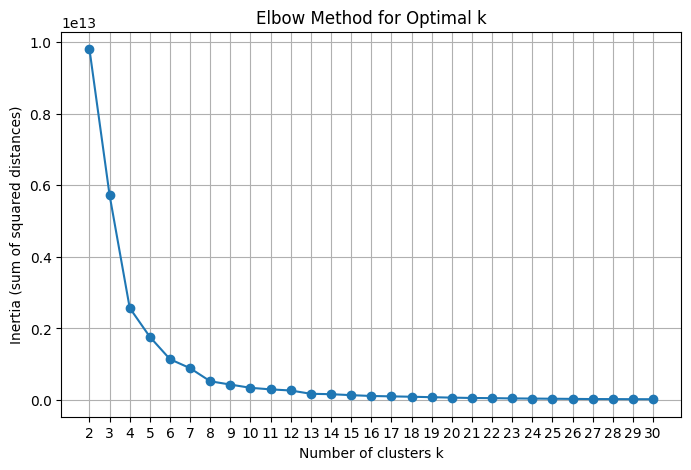

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
Ks = range(2, 31)

clustering_df = X_train.copy()[clustering_cols]

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(clustering_df)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(Ks, inertias, 'o-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.xticks(Ks)
plt.grid(True)
plt.show()

In [ ]:
ideal_k = 5

clustering_df = X_train.copy()[clustering_cols]


kmeans_final = KMeans(n_clusters=ideal_k, random_state=42)
clusters_final = kmeans_final.fit_predict(clustering_df)
clustering_df['cluster'] = clusters_final

# sil_score = silhouette_score(X, clusters_final)
# print(f"Silhouette score for k={ideal_k}: {sil_score:.3f}")

print("Cluster sizes:")
print(clustering_df['cluster'].value_counts().sort_index())

Cluster sizes:
cluster
0    116154
1     93662
2    153286
3     27800
4     62942
Name: count, dtype: int64


The **Elbow Method** (as shown in the scree plot) helps determine the optimal number of clusters by identifying the point where additional clusters yield diminishing returns in reducing intra-cluster variance (inertia).

- At **k=5**, the inertia drops sharply and begins to plateau.
- Using **too few clusters (e.g., 2 or 3)** oversimplifies the data and loses critical distinctions in risk/return profiles.
- Using **too many clusters (e.g., 20+)** leads to overfitting and poor interpretability, as clusters become too granular and less actionable.

- **Balance of granularity and interpretability**: 5 clusters provide meaningful differentiation in risk-return trade-offs without being overly complex.
- **Statistical support**: The inflection point in the Elbow Curve supports this choice.


The 5-cluster segmentation strikes a strong balance between modeling complexity and actionable insight. It effectively distinguishes risk-return profiles, aiding optimized portfolio selection and diversification constraints.

### Understanding the Clusters

#### Predicting expected default and returns

In [ ]:
## Getting an idea of predicted returns
# Classification (Default)
default_pred_train = classification_model.predict(X_train)
default_proba_train = classification_model.predict_proba(X_train)[:, 1]

# Regression (Return)
returns_pred_train = return_model.predict(X_train)

# Regression (Return)
recovery_pred_train = recoveries_model.predict(X_train)

In [ ]:
clustering_df['default_pred'] = default_pred_train
clustering_df['default_proba'] = default_proba_train
clustering_df['returns_pred'] = returns_pred_train
clustering_df['recoveries_pred'] = recovery_pred_train

In [ ]:
clustering_df

,grade,loan_amnt,int_rate,term,dti,revol_util,cluster,default_pred,default_proba,returns_pred,recoveries_pred
179319,1,7200.0,11.99,0,15.05,46.6,0,0,0.142521,0.124386,0.095994
368713,4,18000.0,18.55,1,13.19,65.9,1,1,0.662344,0.118219,0.133321
31060,1,12000.0,11.99,0,16.41,46.9,2,0,0.096765,0.126310,0.103202
506856,3,20000.0,17.57,0,11.52,76.4,1,0,0.155429,0.137693,0.113491
64734,0,12500.0,6.49,0,23.32,50.0,2,0,0.050837,0.119385,0.128870
...,...,...,...,...,...,...,...,...,...,...,...
239417,1,12000.0,10.78,0,4.13,13.6,2,0,0.111103,0.122593,0.092984
5106,3,9000.0,15.59,0,15.40,57.3,2,0,0.205272,0.132542,0.113381
379198,0,5800.0,5.32,0,9.93,19.7,0,0,0.030248,0.120072,0.120147
168476,0,10875.0,8.90,0,19.09,3.0,2,0,0.085285,0.123697,0.107534


#### Analysing Clusters

             mean    median       std
cluster                              
0        0.123775  0.123266  0.008076
1        0.121939  0.121824  0.009239
2        0.121756  0.121693  0.008368
3        0.129733  0.129588  0.011383
4        0.124738  0.123692  0.009842


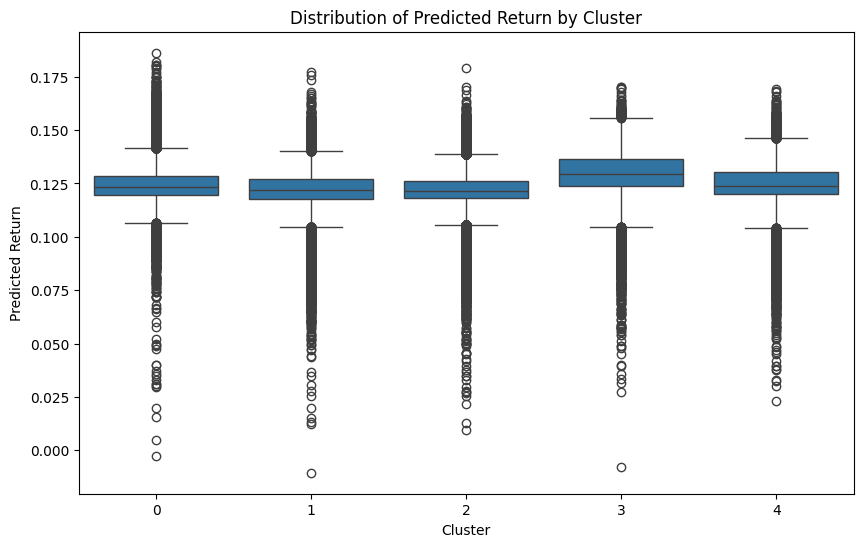

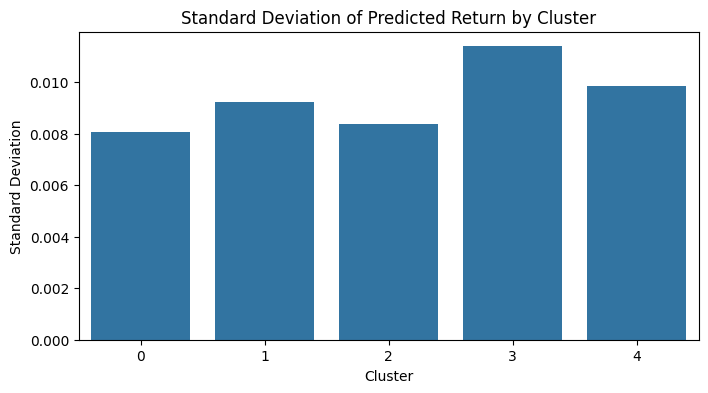

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate descriptive statistics for predicted return by cluster
cluster_stats = clustering_df.groupby('cluster')['returns_pred'].agg(['mean', 'median', 'std'])
print(cluster_stats)

# Boxplot: Distribution of predicted return per cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='returns_pred', data=clustering_df)
plt.title('Distribution of Predicted Return by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Predicted Return')
plt.show()

# Bar plot: Standard deviation of predicted return per cluster
plt.figure(figsize=(8, 4))
sns.barplot(x=cluster_stats.index, y=cluster_stats['std'])
plt.title('Standard Deviation of Predicted Return by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Standard Deviation')
plt.show()


             mean    median       std
cluster                              
0        0.154043  0.145871  0.086211
1        0.202436  0.178567  0.130812
2        0.188987  0.170631  0.124613
3        0.215686  0.197085  0.119440
4        0.196215  0.172800  0.130392


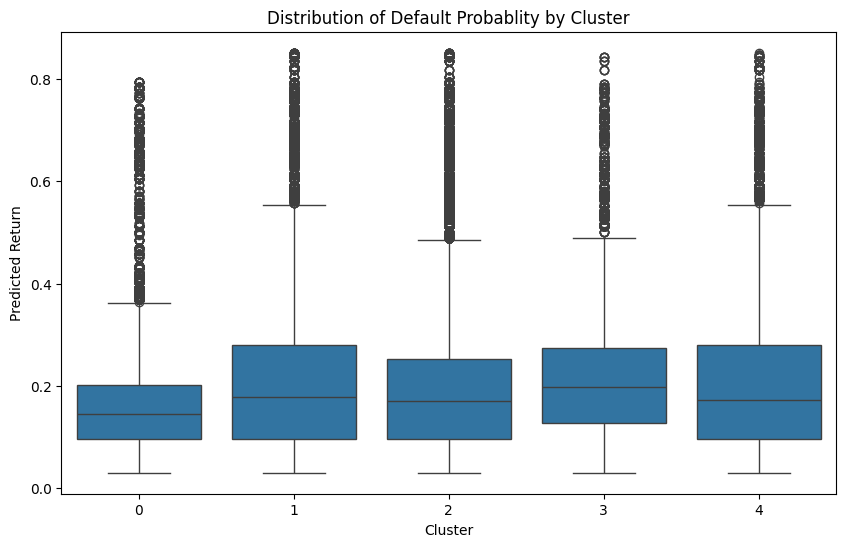

In [ ]:
# prompt: show the distribution of predicted return cluster wise
# i.e, mean ,edian, sd
# and boxplots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_df' is already created as in your provided code

# Calculate descriptive statistics for predicted return by cluster
cluster_stats = clustering_df.groupby('cluster')['default_proba'].agg(['mean', 'median', 'std'])
print(cluster_stats)

# Create box plots of predicted return for each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='default_proba', data=clustering_df)
plt.title('Distribution of Default Probablity by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Predicted Return')
plt.show()


In [ ]:
# prompt: show the distribution of predicted return cluster wise
# i.e, mean ,edian, sd
# and boxplots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_df' is already created as in your provided code

# Calculate descriptive statistics for predicted return by cluster
cluster_stats = clustering_df.groupby('cluster')['default_pred'].agg(['mean',  'std'])
print(cluster_stats)



             mean       std
cluster                    
0        0.006414  0.079830
1        0.029980  0.170533
2        0.027759  0.164281
3        0.036043  0.186401
4        0.031346  0.174253


             mean    median       std
cluster                              
0        0.105945  0.103515  0.011362
1        0.121878  0.120643  0.019721
2        0.115431  0.111662  0.018461
3        0.127426  0.129237  0.019687
4        0.125334  0.125108  0.019712


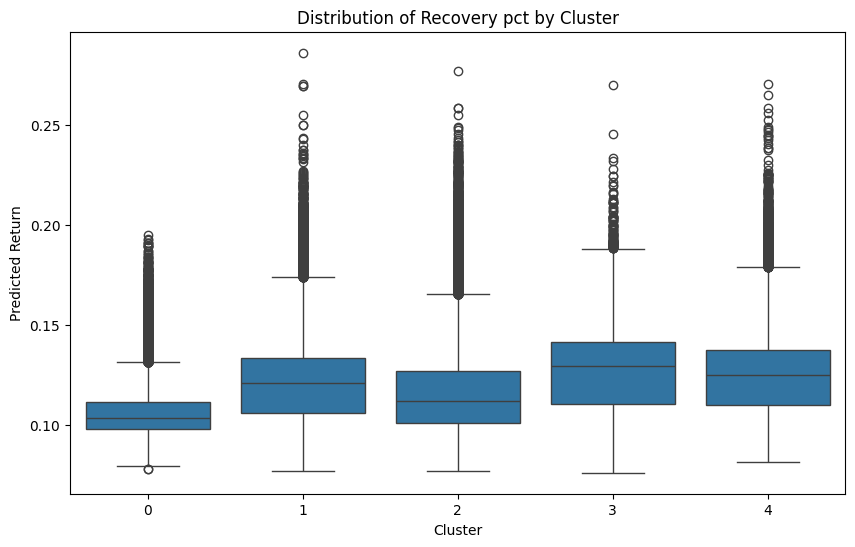

In [ ]:
# prompt: show the distribution of predicted return cluster wise
# i.e, mean ,edian, sd
# and boxplots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_df' is already created as in your provided code

# Calculate descriptive statistics for predicted return by cluster
cluster_stats = clustering_df.groupby('cluster')['recoveries_pred'].agg(['mean', 'median', 'std'])
print(cluster_stats)

# Create box plots of predicted return for each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='recoveries_pred', data=clustering_df)
plt.title('Distribution of Recovery pct by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Predicted Return')
plt.show()


In [ ]:
clustering_df.columns

Index(['grade', 'loan_amnt', 'int_rate', 'term', 'dti', 'revol_util',
       'cluster', 'default_pred', 'default_proba', 'returns_pred',
       'recoveries_pred'],
      dtype='object')

#### In Conclusion
Each loan was assigned to one of 5 clusters using k-means clustering based on loan features. We assess these clusters based on:

- **Predicted Return** (expected gain)
- **Predicted Default Probability** (expected risk)


| Cluster | Mean Return | Std Dev (Return) | Mean Default | Std Dev (Default) | Notes                        |
|---------|-------------|------------------|--------------|-------------------|------------------------------|
| 0       | 12.38%      | 0.81%            | 15.40%       | 8.62%             | Moderate return, lowest risk |
| 1       | 12.19%      | 0.92%            | 20.24%       | 13.08%            | Lower return, higher risk    |
| 2       | 12.18%      | 0.84%            | 18.89%       | 12.46%            | Similar to cluster 1         |
| 3       | 12.97%      | 1.14%            | 21.56%       | 11.94%            | Highest return, highest risk |
| 4       | 12.47%      | 0.98%            | 19.62%       | 13.04%            | Balanced profile             |


- **Cluster 3** has the highest expected return but also the highest default probability and variability in returns.
- **Cluster 0** offers a relatively safer investment with the lowest risk, albeit at a slightly lower return.
- Clusters 1, 2, and 4 lie in between, with risk and return profiles varying modestly.


## Optimization - Question 3

### Running it on test loans
We will be running our optimisation on clustered test loans since they are unkown to all models.

In [ ]:
## Getting an idea of predicted returns
clustering_test = X_test.copy()

# Classification (Default)
default_pred_test = classification_model.predict(X_test)
default_proba_test = classification_model.predict_proba(X_test)[:, 1]

# Regression (Return)
returns_pred_test = return_model.predict(X_test)

# Regression (Return)
recovery_pred_test = recoveries_model.predict(X_test)

clustering_test['default_pred'] = default_pred_test
clustering_test['default_proba'] = default_proba_test
clustering_test['returns_pred'] = returns_pred_test
clustering_test['recovery_pred'] = recovery_pred_test

clusters_final = kmeans_final.predict(X_test.copy()[clustering_cols])
clustering_test['cluster'] = clusters_final

In [ ]:
clustering_test

,loan_amnt,term,int_rate,installment,verification_status,purpose,grade,issue_month,credit_line_loan_gap,revol_util,bc_util,dti,emp_length,home_ownership,default_pred,default_proba,returns_pred,recovery_pred,cluster
32563,18000.0,1,14.49,423.42,2,1,2,9,31.693151,43.8,50.6,20.53,1,1,0,0.239273,0.129956,0.134856,1
54797,1000.0,0,13.98,34.17,2,7,2,10,10.172603,89.3,89.7,12.71,3,2,0,0.112182,0.132324,0.103436,0
359773,18500.0,0,8.18,581.27,0,1,1,10,14.427397,80.1,82.8,23.60,1,2,0,0.085285,0.120965,0.107989,1
622976,4875.0,0,11.99,161.90,0,2,1,4,23.520548,71.9,74.5,15.54,1,1,0,0.095646,0.133968,0.101981,0
410231,10000.0,1,14.65,236.07,2,1,2,1,11.257534,39.1,71.4,32.86,11,3,0,0.359216,0.093403,0.127501,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358891,20000.0,0,13.99,683.46,2,2,2,10,17.926027,60.7,65.4,28.25,1,1,0,0.160769,0.122643,0.126225,1
482720,20000.0,0,8.18,628.39,1,2,1,6,19.931507,73.3,84.8,14.39,1,2,0,0.096423,0.121541,0.099912,1
307614,12575.0,0,20.99,473.70,2,2,4,9,12.175342,41.1,49.5,15.79,0,3,0,0.165287,0.105820,0.108693,2
116332,35000.0,1,18.24,893.35,2,2,3,5,17.673973,60.7,90.0,10.85,7,1,0,0.198215,0.146608,0.133158,3


In [ ]:
clustering_test.groupby('cluster')[['returns_pred','default_proba']] \
    .agg(['count','mean','median','std'])


returns_pred                               default_proba            \
               count      mean    median       std         count      mean   
cluster                                                                      
0              49976  0.123721  0.123229  0.007928         49976  0.153486   
1              40148  0.121832  0.121803  0.009380         40148  0.203964   
2              65483  0.121793  0.121728  0.008318         65483  0.189784   
3              11721  0.129956  0.129555  0.010896         11721  0.213851   
4              27177  0.124796  0.123787  0.009737         27177  0.196429   

                             
           median       std  
cluster                      
0        0.145871  0.085007  
1        0.178567  0.132157  
2        0.171752  0.125106  
3        0.194196  0.117495  
4        0.172800  0.130352

### Optimisation Logic
#### Optimization Model Summary

This portfolio optimization problem is modeled as a **Mixed Integer Program (MIP)** and solved using the Gurobi solver. It is based on a multi-knapsack, Markowitz-type formulation that maximizes the expected return while incorporating realistic investment constraints.

#### Objective Function

The objective is to **maximize the expected dollar return** from the selected loan portfolio:

$$
\text{Maximize: } \sum_i x_i \cdot y_i \cdot \left[(1 + r_i)(1 - d_i) + d_i \cdot \rho_i \right]
$$

Where:
- $$ x_i \in \{0, 1\} $$: binary decision variable — whether to invest in loan *i*
-  $$ y_i \in \mathbb{Z}_+ $$: integer — amount invested in loan *i*
- $$ r_i $$ : predicted return of loan *i*
- $$ d_i $$: predicted default probability of loan *i*
- $$ \rho_i $$: predicted recovery rate if loan *i* defaults

#### Decision Variables

- $$ x_i $$: Binary variable — 1 if loan *i* is selected, 0 otherwise  
- $$ y_i $$: Integer variable — dollar amount allocated to loan *i*


#### Constraints

1. **Loan Selection Limit**  
   Limit the number of selected loans:
   $$
   \sum_i x_i \leq \text{max_loans}
   $$

2. **Budget Constraint**  
   Total invested amount cannot exceed the available budget:
   $$
   \sum_i x_i \cdot y_i \leq \text{budget}
   $$

3. **Per-Loan Budget Cap**  
   No single loan can receive more than a fixed share of the total budget:
   $$
   y_i \leq \text{BudgetSharePerLoan} \cdot \text{budget}
   \quad \forall i
   $$

4. **Loan Size Limit**  
   Investment in a loan cannot exceed a fixed share of that loan’s own amount:
   $$
   y_i \leq \text{PctOfLoansToInvest} \cdot \text{loan\_amnt}_i
   \quad \forall i
   $$

5. **Default Risk Threshold**  
   Each selected loan must have a default probability below the allowed threshold:
   $$
   x_i \cdot d_i \leq \text{max_default_rate}
   \quad \forall i
   $$
   Here we have used the **25th percentile** limit of all predicted default probablities to pick the safest loans

6. **Cluster Diversification**  
   Limit the number of selected loans from each risk cluster:
   $$
   \sum_{i \in C_k} x_i \leq \text{cluster\_limit}_k
   \quad \forall \text{clusters } k
   $$


#### Optional Enhancements

- Compute **actual net return** if `Net_return_pct` is available (e.g., historical realized return).
- Option to **export selected portfolio to CSV** for further analysis.


### Coding The Optimiser

In [45]:
# Installing and importing the Gurobi package in Python
!pip install gurobipy
import gurobipy as gp
from gurobipy import Model, GRB

# params = {
# "WLSACCESSID":"80c5250b-8700-40e4-a4be-7ae09043ce25",
# "WLSSECRET":"7eb489d4-03b9-46d0-8dbd-593b43020284",
# "LICENSEID":2609414,
# }
# env = gp.Env(params=params)

params = {
"WLSACCESSID": '28fb99c1-4c1d-4d73-b325-94e3643aff90',
"WLSSECRET": '2b93619d-e319-47fc-8cae-95f37842e041',
"LICENSEID": 2613080,
}
env = gp.Env(params=params)

##############
## NOTE: Due to the expiry of licenses of all teammates, we have requested our classmate (Renisa Mukherjee - renisasm@andrew.cmu.edu) to lend her credentials for the optimisation modelling
##############

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2613080
Academic license 2613080 - for non-commercial use only - registered to re___@andrew.cmu.edu


In [ ]:
optimization_df=clustering_test.copy()

# -----------------------------
# Set optimization parameters
# -----------------------------
budget = 250000                    # Total dollar amount available for investment
max_loans = 100                   # Select exactly 10 loans
max_avg_default_rate = clustering_df.default_proba.describe().loc['25%']       # Limit average default probability to 15%

# Cluster diversification constraints
cluster_limits = {
    0: 0.30,    #Least Risk
    #1: 0.20,
    #2: 0.20,
    3: 0.10,    # HIghest Risk
    #4: 0.20
}

In [ ]:
def optimize_portfolio(optimization_df, budget, max_loans,
                       max_default_rate=0.15,   #hard limit for a loan default rate
                       cluster_limits_percent=None,
                       BudgetSharePerLoan = 0.2,    #max pct of budget that can be invested in a single loan
                       PctOfLoansToInvest = 0.2,    #max pct of a loan's total amount that one can invest in
                       net_ret_pct=False,
                       save_csv=False):

    m = Model(env=env)
    m.setParam("OutputFlag", 0)

    #  Variable Declaration
    x = m.addVars(optimization_df.index, vtype=GRB.BINARY, name="x")   #whether to invest in a loan
    y = m.addVars(optimization_df.index, vtype=GRB.INTEGER,lb=1, name="y")  #amount invested in a loan

    #  Ojective
    m.setObjective(sum((1 + optimization_df.loc[i, 'returns_pred']) * x[i] * y[i] * (1 - optimization_df.loc[i, 'default_proba'])
                        + optimization_df.loc[i, 'default_proba'] * optimization_df.loc[i, 'recovery_pred'] * x[i] * y[i]
                        for i in optimization_df.index),GRB.MAXIMIZE)

    # Select exactly 100 loans
    m.addConstr(sum(x[i] for i in optimization_df.index) <= max_loans, "loan_count")

    # Stay within the total budget
    m.addConstr(sum( x[i] * y[i]for i in optimization_df.index) <= budget,name="budget")

    #Dont invest more than alloted share in a single loan
    m.addConstrs((y[i] <= BudgetSharePerLoan * budget for i in optimization_df.index), name="budget_share")

    #Dont invest more than alloted amount per loan
    m.addConstrs((y[i] <= PctOfLoansToInvest * optimization_df.loc[i, 'loan_amnt'] for i in optimization_df.index), name="pct_of_loan")

    #hard limit for loan risk
    m.addConstrs((x[i]*optimization_df.loc[i, 'default_proba'] <= max_default_rate for i in optimization_df.index), name="risk_limit")

    # Apply cluster limits
    for cluster_id, max_pct in cluster_limits_percent.items():
        cluster_indices = optimization_df[optimization_df['cluster'] == cluster_id].index
        max_count = int(max_pct * max_loans)
        m.addConstr(sum(x[i] for i in cluster_indices) <= max_count, f"cluster_{cluster_id}_cap")

    m.optimize()

    if m.status == GRB.OPTIMAL:
    # 1) Identify selected loans
      selected_indices = [i for i in optimization_df.index if x[i].X > 0.5]
      portfolio = optimization_df.loc[selected_indices].copy()

      # 2) Compute total invested amount and weighted numerators
      total_invested = 0.0
      weighted_return_num = 0.0
      weighted_default_num = 0.0
      loan_investments = []
      for i in selected_indices:
          amt = x[i].X * y[i].X
          loan_investments.append(amt)
          total_invested += amt
          weighted_return_num  += optimization_df.loc[i, 'returns_pred']  * amt
          weighted_default_num += optimization_df.loc[i, 'default_proba'] * amt

      # 3) Compute weighted averages
      weighted_return       = weighted_return_num  / total_invested
      weighted_default_risk = weighted_default_num / total_invested

      # 4) Efficiency metric (objective value per dollar invested)
      efficiency = m.objVal / total_invested

      # 5) Number of loans invested in
      num_loans = len(selected_indices)

      # 6) Reporting
      print(f"💰 Total Investment:             ${total_invested:,.2f}")
      print(f"📈 Weighted Average Return:       {weighted_return:.2%}")
      print(f"💰 Total Return:             ${(1+weighted_return)*total_invested:,.2f}")
      print(f"🔢 Number of Loans Invested In:   {num_loans}")
      print(f"📉 Weighted Average Default Risk: {weighted_default_risk:.2%}")
      print(f"🎯 Expected Ending Amount:      {efficiency:.4f}")

      if net_ret_pct and 'Net_return_pct' in optimization_df.columns:
          weighted_net_return_num = sum(
              optimization_df.loc[i, 'Net_return_pct'] * x[i].X * y[i].X
              for i in selected_indices
          )
          weighted_net_return = weighted_net_return_num / total_invested
          print(f"🧾 Net Actual Weighted Return pct: {weighted_net_return:.2%}")
      else:
          weighted_net_return = None


      print("📊 Loans per Cluster:")
      print(portfolio['cluster'].value_counts().sort_index())

      # 7) Optionally save a pretty CSV
      if save_csv:

          portfolio_pretty = portfolio.rename(columns={
              'loan_amnt':       'Loan Amount ($)',
              'returns_pred':    'Expected Return (%)',
              'recovery_pred':   'Expected Recovery (%)',
              'default_proba':   'Risk of Default (%)',
              'cluster':         'Risk Cluster'
          })
          # Format columns
          portfolio_pretty['Expected Return (%)']    = (portfolio_pretty['Expected Return (%)']    * 100).round(2)
          portfolio_pretty['Expected Recovery (%)']    = (portfolio_pretty['Expected Recovery (%)']    * 100).round(2)
          portfolio_pretty['Interest Rate (%)']    = (portfolio_pretty['int_rate'] ).round(2)
          portfolio_pretty['Risk of Default (%)']    = (portfolio_pretty['Risk of Default (%)']    * 100).round(2)
          portfolio_pretty['Loan Amount ($)']        = portfolio_pretty['Loan Amount ($)'].round(2)
          portfolio_pretty['Amount Invested ($)']    = loan_investments

          portfolio_pretty = portfolio_pretty[["Loan Amount ($)","term","Interest Rate (%)",
                                               "Risk of Default (%)","Expected Return (%)","Expected Recovery (%)",
                                               "Risk Cluster","Amount Invested ($)"]]

          portfolio_pretty.to_csv("optimized_loan_portfolio.csv", index=False)

      # 8) Return updated metrics
      return portfolio, weighted_return, weighted_default_risk, total_invested, efficiency, num_loans, weighted_net_return

    else:
        print(f"⚠️ Could not find a feasible solution for Budget = {budget}, Loans = {max_loans}. Skipping...")
        return None, None, None, None, None, None


### Portfolio Optimization Summary

In [ ]:
portfolio, avg_return, avg_default, total_investment, efficiency, num_loans, weighted_net_ret = optimize_portfolio(
      clustering_test,
      budget=200000,
      max_loans=100,
      max_default_rate=max_avg_default_rate,
      cluster_limits_percent=cluster_limits,
      BudgetSharePerLoan=0.01,
      PctOfLoansToInvest=0.5,
      save_csv=True
  )

💰 Total Investment:             $200,000.00
📈 Weighted Average Return:       12.86%
💰 Total Return:             $225,720.05
🔢 Number of Loans Invested In:   100
📉 Weighted Average Default Risk: 3.21%
🎯 Expected Ending Amount:      1.0968
📊 Loans per Cluster:
cluster
0    30
1    22
2    25
3     6
4    17
Name: count, dtype: int64


Using a multi-knapsack integer programming approach inspired by the Markowitz framework, we constructed an optimized portfolio of 100 loans under the following constraints:

- Budget: \$200,000  
- Maximum investment per loan: 1% of total budget to ensure atleast 100 loans are invested in
- Maximum fraction of each loan invested: 50%  
- Default risk capped per loan  
- Diversification enforced through cluster-level allocation limits  

#### Optimization Results

| Metric                             | Value           |
|------------------------------------|-----------------|
| Total Investment                   | \$200,000.00    |
| Weighted Average Return            | 12.86%          |
| Total Expected Return              | \$225,720.05    |
| Number of Loans Invested In        | 100             |
| Weighted Average Default Risk      | 3.21%           |
| Expected Ending Amount (Multiplier)| 1.0968          |
| Loans per Cluster                  | C0: 30, C1: 22, C2: 25, C3: 6, C4: 17 |


This optimized portfolio demonstrates clear improvements over the simple rule-based strategies explored previously:

- Higher average return at lower average risk  
- Balanced allocation across loan clusters  
- Enforcement of diversification and exposure constraints  
- Better control over downside risk through position limits  


The optimization approach provides a structured and risk-aware method of portfolio construction that significantly outperforms heuristic strategies used in prior analysis. It ensures capital is allocated efficiently while adhering to risk and diversification constraints.


In [ ]:
import time
budget = float(input("What is your budget \n"))
maxloans = int(input("What is the max number of loans you want to invets in? \n"))
BudgetSharePerLoan = float(input("What is the max portion of budget that can be invested in a single loan? (out of 1)\n"))
PctOfLoansToInvest = float(input("What is the max portion of a loan's total amount that one can invest in?\n"))
start = time.time()
portfolio, avg_return, avg_default, total_investment, efficiency, num_loans, weighted_net_ret = optimize_portfolio(
      clustering_test,
      budget=budget,
      max_loans=maxloans,
      max_default_rate=max_avg_default_rate,
      cluster_limits_percent=cluster_limits,
      BudgetSharePerLoan=BudgetSharePerLoan,
      PctOfLoansToInvest=PctOfLoansToInvest,
      save_csv=True
  )
end = time.time()
print(f"Time taken: {end - start} seconds")

What is your budget 
100000
What is the max number of loans you want to invets in? 
20
What is the max portion of budget that can be invested in a single loan? (out of 1)
0.1
What is the max portion of a loan's total amount that one can invest in?
0.3
💰 Total Investment:             $100,000.00
📈 Weighted Average Return:       14.49%
💰 Total Return:             $114,486.88
🔢 Number of Loans Invested In:   18
📉 Weighted Average Default Risk: 3.70%
🎯 Expected Ending Amount:      1.1078
📊 Loans per Cluster:
cluster
0    4
1    4
2    2
3    2
4    6
Name: count, dtype: int64
Time taken: 57.07225966453552 seconds


## Sensitivity Analysis - Question 4

### Adding back real data

In [ ]:
actual_test_data = clustering_test.copy()
actual_test_data = actual_test_data[['loan_amnt','term','int_rate','default_proba','returns_pred','recovery_pred','cluster']]
actual_test_data['actual_return_pct'] = y_test_ret
actual_test_data['actual_recovery_pct'] = y_test_rec
actual_test_data['actual_default'] = y_test_def
actual_test_data['Net_return_pct'] = np.where(
    actual_test_data['actual_default'] == 0,
    actual_test_data['actual_return_pct'] + 1,
    actual_test_data['actual_recovery_pct']
)

import numpy as np

# Base logic
conditions = [
    actual_test_data['actual_default'] == 0,
    (actual_test_data['actual_default'] == 1) & (actual_test_data['actual_recovery_pct'].notnull()),
    (actual_test_data['actual_default'] == 1) & (actual_test_data['actual_recovery_pct'].isnull())
]

choices = [
    actual_test_data['actual_return_pct'] + 1,
    actual_test_data['actual_recovery_pct'],
    actual_test_data['recovery_pred']  # fallback if actual recovery is missing
]

actual_test_data['Net_return_pct'] = np.select(conditions, choices, default=np.nan)


In [ ]:
actual_test_data

,loan_amnt,term,int_rate,default_proba,returns_pred,recovery_pred,cluster,actual_return_pct,actual_recovery_pct,actual_default,Net_return_pct
32563,18000.0,1,14.49,0.239239,0.129956,0.134856,1,0.172423,NaN,0,1.172423
54797,1000.0,0,13.98,0.112159,0.132324,0.103436,0,0.152692,NaN,0,1.152692
359773,18500.0,0,8.18,0.085290,0.120965,0.107989,1,0.124271,NaN,0,1.124271
622976,4875.0,0,11.99,0.095661,0.133968,0.101981,0,0.145061,NaN,0,1.145061
410231,10000.0,1,14.65,0.359306,0.093403,0.127501,2,0.170192,NaN,0,1.170192
...,...,...,...,...,...,...,...,...,...,...,...
358891,20000.0,0,13.99,0.160821,0.122643,0.126225,1,0.154998,NaN,0,1.154998
482720,20000.0,0,8.18,0.096457,0.121541,0.099912,1,0.124402,NaN,0,1.124402
307614,12575.0,0,20.99,0.165295,0.105820,0.108693,2,-0.064937,0.083497,1,0.083497
116332,35000.0,1,18.24,0.198095,0.146608,0.133158,3,0.202874,NaN,0,1.202874


### Running multiple Loan Picking Methodlogies

In [ ]:
#budgets = np.concatenate([np.arange(5000, 50000, 5000),np.arange(50000, 150000, 10000), np.arange(150000, 1000001, 50000)])
#loan_counts = np.concatenate([np.arange(1, 15, 1), np.arange(15, 50, 5), np.arange(50, 151, 10)])
budgets = [5000, 10000, 15000,20000,25000, 50000, 100000, 150000, 200000,250000,300000,500000]
loan_counts = [1,2,3,4,5, 10, 15,20,25,30,50,75,100,150]
import random
def calculate_net_return(df, indices, budget):
    n = len(indices)
    invest_per_loan = budget / n
    net_returns = df.loc[indices, 'Net_return_pct'] * invest_per_loan
    total_return = net_returns.sum()
    net_return_pct = total_return / budget
    return net_return_pct

# -----------------------------
# Run sensitivity analysis
# -----------------------------
results = []

for b in budgets:
    for lc in loan_counts:
        print(f"\n🔍 Testing with Budget = {b}, Loans = {lc}")

        cluster_limits_percent = {
            1: 0.2,
            3: 0.2
        }

        # Run optimization
        opt_portfolio, opt_weighted_ret, opt_weighted_risk, opt_total_inv, efficiency, opt_num_loans,weighted_net_return = optimize_portfolio(
            actual_test_data,
            budget=b,
            max_loans=lc,
            max_default_rate=max_avg_default_rate,
            cluster_limits_percent=cluster_limits_percent,
            BudgetSharePerLoan=0.2,
            PctOfLoansToInvest=0.4,
            net_ret_pct=True,
            save_csv=False
        )

        # Default fallback values
        random_ret = top_ret = safe_ret = None

        # Baseline strategies only if enough loans are present
        affordable_loans = actual_test_data
        if len(affordable_loans) >= lc:
            # 1. Random Strategy
            random_indices = np.random.choice(affordable_loans.index, lc, replace=False)
            random_ret = calculate_net_return(affordable_loans, random_indices, b)
            print(f"🧪 Random Strategy Net Return: {random_ret:.2%}")

            # 2. Top Return Strategy
            top_ret_indices = affordable_loans.sort_values('returns_pred', ascending=False).head(lc).index
            top_ret = calculate_net_return(affordable_loans, top_ret_indices, b)
            print(f"🚀 Top Return Strategy Net Return: {top_ret:.2%}")

            # 3. Safe Strategy
            safe_indices = affordable_loans.sort_values('default_proba', ascending=True).head(lc).index
            safe_ret = calculate_net_return(affordable_loans, safe_indices, b)
            print(f"🛡️  Safe (Low Risk) Strategy Net Return: {safe_ret:.2%}")
        else:
            print("⚠️ Not enough affordable loans to run baseline strategies for this config.")

        # Append results to list
        results.append({
            "budget": b,
            "num_loans": lc,
            "opt_loans_invested": opt_num_loans,
            "opt_weighted_return": opt_weighted_ret,
            "opt_actual_net_return": weighted_net_return,
            "opt_total_invested": opt_total_inv,
            "random_net_return": random_ret,
            "top_pred_return": top_ret,
            "safe_return": safe_ret
        })


🔍 Testing with Budget = 5000, Loans = 1
💰 Total Investment:             $1,000.00
📈 Weighted Average Return:       14.85%
💰 Total Return:             $1,148.49
🔢 Number of Loans Invested In:   1
📉 Weighted Average Default Risk: 3.02%
🎯 Expected Ending Amount:      1.1176
🧾 Net Actual Weighted Return pct: 117.80%
📊 Loans per Cluster:
cluster
4    1
Name: count, dtype: int64
🧪 Random Strategy Net Return: 119.57%
🚀 Top Return Strategy Net Return: 4.96%
🛡️  Safe (Low Risk) Strategy Net Return: 112.61%

🔍 Testing with Budget = 5000, Loans = 2
💰 Total Investment:             $2,000.00
📈 Weighted Average Return:       14.81%
💰 Total Return:             $2,296.26
🔢 Number of Loans Invested In:   2
📉 Weighted Average Default Risk: 3.02%
🎯 Expected Ending Amount:      1.1175
🧾 Net Actual Weighted Return pct: 118.38%
📊 Loans per Cluster:
cluster
2    1
4    1
Name: count, dtype: int64
🧪 Random Strategy Net Return: 57.45%
🚀 Top Return Strategy Net Return: 9.63%
🛡️  Safe (Low Risk) Strategy Net Re

In [ ]:
results_df = pd.DataFrame(results)

# View summary
display(results_df.head())

# Save results
results_df.to_csv("sensitivity_results.csv", index=False)


,budget,num_loans,opt_loans_invested,opt_weighted_return,opt_actual_net_return,opt_total_invested,random_net_return,top_pred_return,safe_return
0,5000,1,1,0.148493,1.178017,1000.0,1.195749,0.049648,1.126125
1,5000,2,2,0.148128,1.183797,2000.0,0.574468,0.096337,1.130398
2,5000,3,3,0.147234,1.174664,3000.0,1.160492,0.467562,1.126806
3,5000,4,4,0.146351,1.168997,4000.0,0.887948,0.651203,1.128648
4,5000,5,5,0.146547,1.169523,5000.0,1.167108,0.753578,1.125792


In [ ]:
results_df.describe()

,budget,num_loans,opt_loans_invested,opt_weighted_return,opt_actual_net_return,opt_total_invested,random_net_return,top_pred_return,safe_return
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,135416.666667,35.000000,11.202381,0.144298,1.155218,84402.309524,0.962071,0.726072,1.079597
std,147301.491985,43.040157,14.530810,0.004875,0.031814,109279.143159,0.197295,0.296385,0.046123
min,5000.000000,1.000000,1.000000,0.129096,0.924898,1000.000000,0.032835,0.049648,0.999679
25%,18750.000000,4.000000,4.000000,0.142082,1.151854,12000.000000,0.913563,0.651203,1.039423
50%,75000.000000,17.500000,6.000000,0.146358,1.164983,27500.000000,0.983045,0.881323,1.076329
75%,212500.000000,50.000000,12.000000,0.146668,1.172554,123940.000000,1.095066,0.917142,1.126125
max,500000.000000,150.000000,95.000000,0.151402,1.183797,500000.000000,1.195749,0.940489,1.130398


### Sensitivity Analysis of Loan Selection Strategies (Profit % View)

#### Objective

This study evaluates how different loan selection strategies perform under varying portfolio sizes and budget constraints, with the objective of maximizing **net profit** while minimizing risk.

#### Methodology

A structured **sensitivity analysis** was conducted across:

- **12 budget levels**: from \$5,000 to \$500,000  
- **14 loan count levels**: from 1 to 150 loans  

This resulted in **168 unique portfolio scenarios**, tested using four distinct strategies:

#### Strategies Compared

| Strategy                     | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| **Our Model**               | Integer programming model that optimizes loan selection and investment size |
| **Random Strategy**         | Randomly picks `n` loans and splits budget evenly                          |
| **Top Return Strategy**     | Picks loans with highest predicted returns                                  |
| **Safe Strategy**           | Picks loans with lowest predicted default probabilities                     |

The optimization was solved using **Gurobi**, with constraints on budget, loan count, cluster diversification, and risk caps.  
- We cannot invest more than 20% of our budget ona  single loan
- We cannot fund more than 20% of the entire loan as well
-Some clusters have limits as to how mant loans can we pick from them (3 and 0)
Baseline strategies used actual historical return data (`Net_return_pct`) for real-world performance comparison.

#### Results Summary (in Profit or Loss %)

Summary Statistics

| Metric                     | Our Model | Random Strategy | Top Return | Safe Strategy |
|----------------------------|-----------|-----------------|------------|---------------|
| **Mean Profit (%)**        | **15.52%**| **-3.79%**       | **-27.39%** | **7.96%**     |
| **Standard Deviation**     | 3.18%     | 19.73%          | 29.64%     | 4.61%         |
| **Minimum Profit (%)**     | -7.51%    | -96.72%         | -95.04%    | -0.03%        |
| **Maximum Profit (%)**     | 18.38%    | 19.57%          | -5.95%     | 13.04%        |

> _Note: Profit (%) is calculated as `(Net Return - 1) × 100`._



In [ ]:
snesitivity_results = results_df.copy()

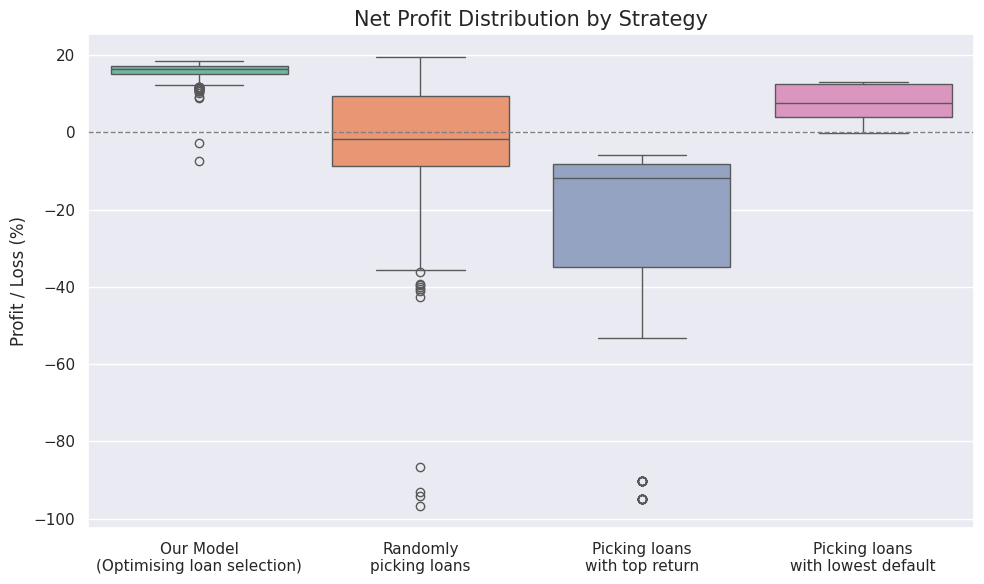

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rename with wrapped labels
rename_map = {
    'opt_actual_net_return': "Our Model\n(Optimising loan selection)",
    'random_net_return': "Randomly\npicking loans",
    'top_pred_return': "Picking loans\nwith top return",
    'safe_return': "Picking loans\nwith lowest default"
}

# Compute profit/loss (%)
plot_df = results_df.copy()
for old_col, new_label in rename_map.items():
    plot_df[new_label] = (plot_df[old_col] - 1) * 100

strategy_cols = list(rename_map.values())

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.boxplot(data=plot_df[strategy_cols], palette="Set2")

# Formatting
plt.title("Net Profit Distribution by Strategy", fontsize=15)
plt.ylabel("Profit / Loss (%)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=0)  # No tilt needed, wrapped labels
plt.tight_layout()
plt.show()



#### Boxplot Comparison

- **Our Model** has the highest median and tightest interquartile range.
- **Random and top-return strategies** have wider spreads and more outliers.
- **Safe strategy** has lower risk, but lower return ceiling.



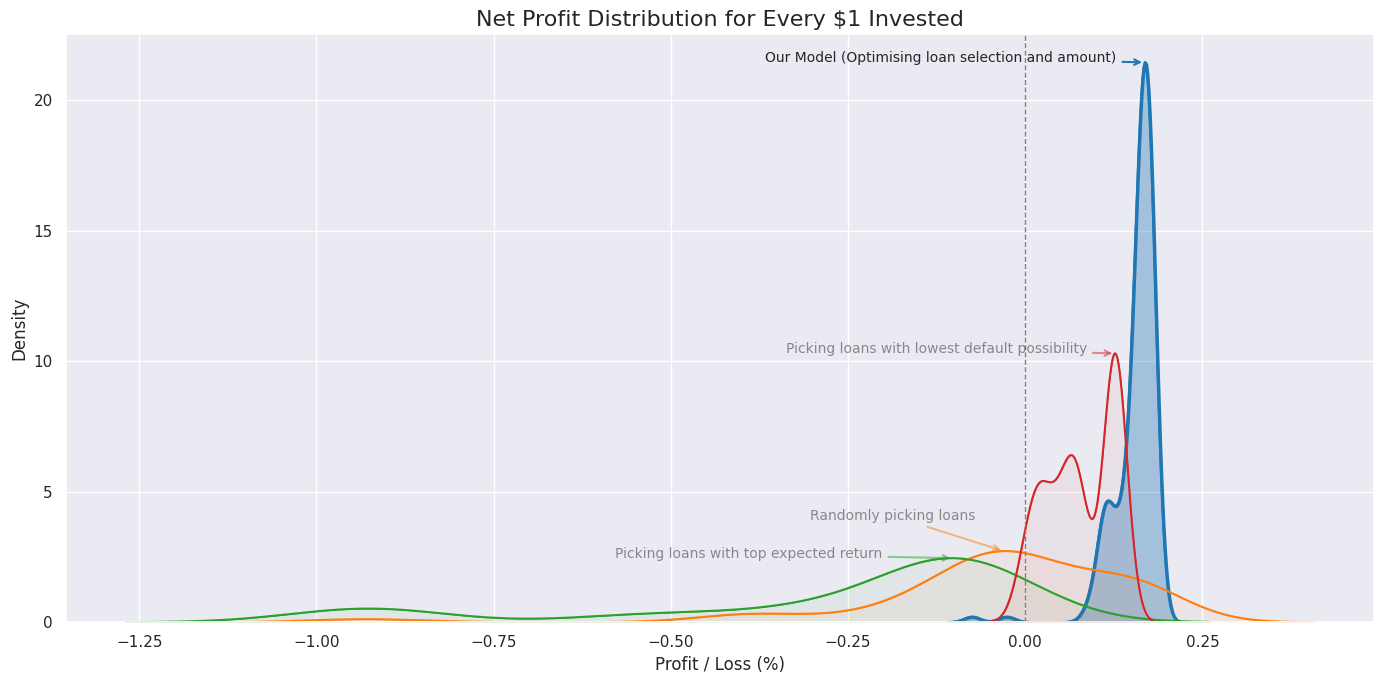

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rename strategy columns
rename_map = {
    'opt_actual_net_return': "Our Model (Optimising loan selection and amount)",
    'random_net_return': "Randomly picking loans",
    'top_pred_return': "Picking loans with top expected return",
    'safe_return': "Picking loans with lowest default possibility"
}

# Adjust returns to profits (center around 0)
plot_df = results_df.copy()
for col in rename_map:
    plot_df[rename_map[col]] = (plot_df[col] - 1)  # convert to profit %

strategy_cols = list(rename_map.values())

plt.figure(figsize=(14, 7))
sns.set(style="darkgrid")

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot KDE curves
for idx, col in enumerate(strategy_cols):
    is_our_model = "Our Model" in col
    sns.kdeplot(
        plot_df[col],
        label=col,
        linewidth=2.5 if is_our_model else 0.5,
        fill=True,
        alpha=0.35 if is_our_model else 0.05,
        color=colors[idx]
    )

# Add labels + arrows with opacity
for idx, col in enumerate(strategy_cols):
    kde = sns.kdeplot(plot_df[col], bw_adjust=1, color=colors[idx]).get_lines()[-1]
    x_data, y_data = kde.get_data()
    peak_idx = y_data.argmax()
    peak_x = x_data[peak_idx]
    peak_y = y_data[peak_idx]

    is_our_model = "Our Model" in col
    alpha_text = 1.0 if is_our_model else 0.5
    y_label = peak_y + (1.2 if "Randomly picking loans" in col else 0)
    x_label = peak_x - (0.1 if "Picking loans with top expected return" in col else 0.04)

    plt.annotate(
        col,
        xy=(peak_x, peak_y),
        xytext=(x_label, y_label),
        textcoords="data",
        arrowprops=dict(
            arrowstyle="->", color=colors[idx], lw=1.5, alpha=alpha_text
        ),
        fontsize=10,
        ha='right',
        alpha=alpha_text
    )

plt.title("Net Profit Distribution for Every $1 Invested", fontsize=16)
plt.xlabel("Profit / Loss (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # break-even reference
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()


#### Kernel Density Plot (KDE)

- **Our Model** shows a narrow, high peak centered around ~15% profit with low variance.
- **Random strategy** has wide distribution and heavy tails (unpredictable).
- **Top return** is the worst performer, often yielding losses due to high risk.
- **Safe strategy** is more stable but still underperforms compared to optimized allocation.


## Conslusion

- **Our Optimized Model** consistently delivers **higher and more stable profits** than all baselines. Here we pick which loans and how much to invest in them from a vry small subset of *safe* loans to begin with.
- **Clustering** hekps with risk spread and understanding the loans even before complex preeictionare done
- **Random and naive strategies** lead to volatile and often negative outcomes.
- **Safe strategies** offer some protection but fail to reach the efficiency of the optimized portfolio.

This demonstrates the clear advantage of **mathematical optimization** in risk-constrained loan selection.
